In [1]:
#I have made changes to the code and included inference graphs that I want to use in the Streamlit app.


# Hand written text classification Project

This notebooks shows how to define and train a simple Neural-Network with PyTorch and use it via skorch with SciKit-Learn.

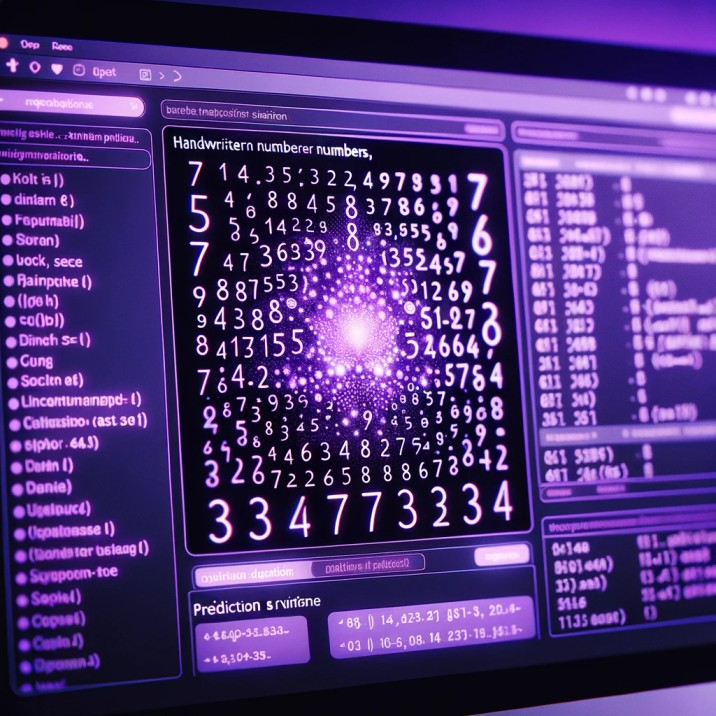

**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb), we recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

If you are running in colab, you should install the dependencies and download the dataset by running the following cell:

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Loading Data
Using SciKit-Learns ```fetch_openml``` to load MNIST data.

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False, version=1)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

C:\Users\sahoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape

(52500, 784)

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.<br />
The above ```featch_mldata``` method to load MNIST returns ```data``` and ```target``` as ```uint8``` which we convert to ```float32``` and ```int64``` respectively.

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

To avoid big weights that deal with the pixel values from between [0, 255], we scale `X` down. A commonly used range is [0, 1].

In [6]:
X /= 255.0

In [7]:
X.min(), X.max()

(0.0, 1.0)

Note: data is not normalized.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((52500, 784), (52500,), (17500, 784), (17500,))

### Print a selection of training images and their labels

In [11]:
def plot_example(X, y):
    """Plot the first 100 images in a 10x10 grid."""
    plt.figure(figsize=(15, 15))  # Set figure size to be larger (you can adjust as needed)

    for i in range(10):  # For 10 rows
        for j in range(10):  # For 10 columns
            index = i * 10 + j
            plt.subplot(10, 10, index + 1)  # 10 rows, 10 columns, current index
            plt.imshow(X[index].reshape(28, 28))  # Display the image
            plt.xticks([])  # Remove x-ticks
            plt.yticks([])  # Remove y-ticks
            plt.title(y[index], fontsize=8)  # Display the label as title with reduced font size
            
    plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing (you can modify as needed)
    plt.tight_layout()  # Adjust the spacing between plots for better visualization
    plt.show()  # Display the entire grid.
    


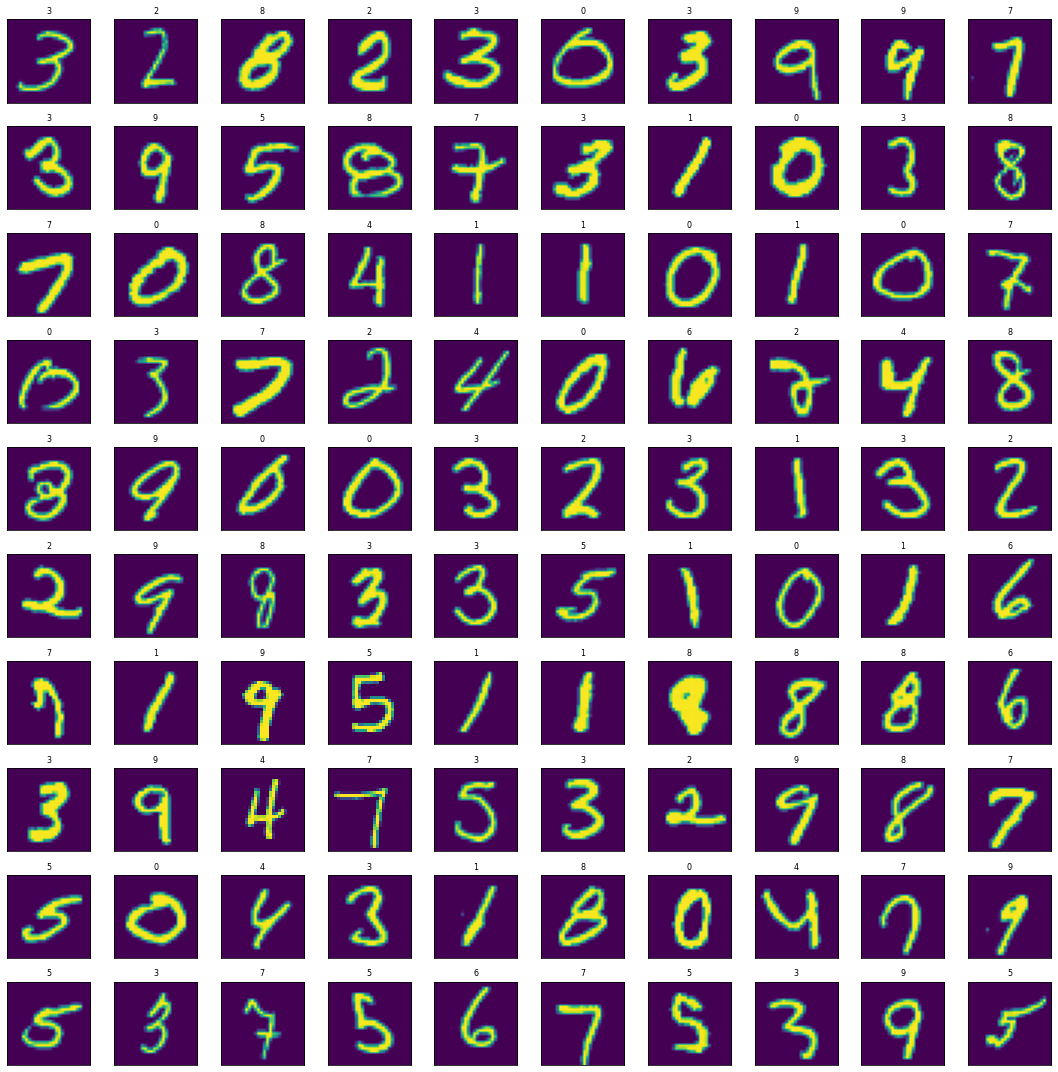

In [12]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch
Simple, fully connected neural network with one hidden layer. Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [13]:
import torch
from torch import nn
import torch.nn.functional as F

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
device

'cpu'

In [16]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

In [17]:
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

A Neural network in PyTorch's framework.

In [18]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

skorch allows to use PyTorch's networks in the SciKit-Learn setting:

In [19]:
from skorch import NeuralNetClassifier

In [20]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [21]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8309       0.8865        0.4049  1.7647
      2        0.4323       0.9124        0.3047  1.3796
      3        0.3606       0.9215        0.2682  1.6794
      4        0.3191       0.9297        0.2424  1.6739
      5        0.2969       0.9360        0.2192  1.2498
      6        0.2760       0.9395        0.2040  1.2259
      7        0.2596       0.9440        0.1911  1.2384
      8        0.2463       0.9476        0.1776  1.1207
      9        0.2357       0.9501        0.1697  1.3467
     10        0.2272       0.9521        0.1650  1.3855
     11        0.2198       0.9539        0.1569  0.9915
     12        0.2074       0.9547        0.1536  1.3162
     13        0.2037       0.9558        0.1487  1.0429
     14        0.1985       0.9545        0.1468  1.0553
     15        0.1960       0.9583        0.1392  1.0828
     16        0.1885       0.9

## Prediction

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
y_pred = net.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9614857142857143

An accuracy of about 96% for a network with only one hidden layer is not too bad.

Let's take a look at some predictions that went wrong:

In [25]:
error_mask = y_pred != y_test

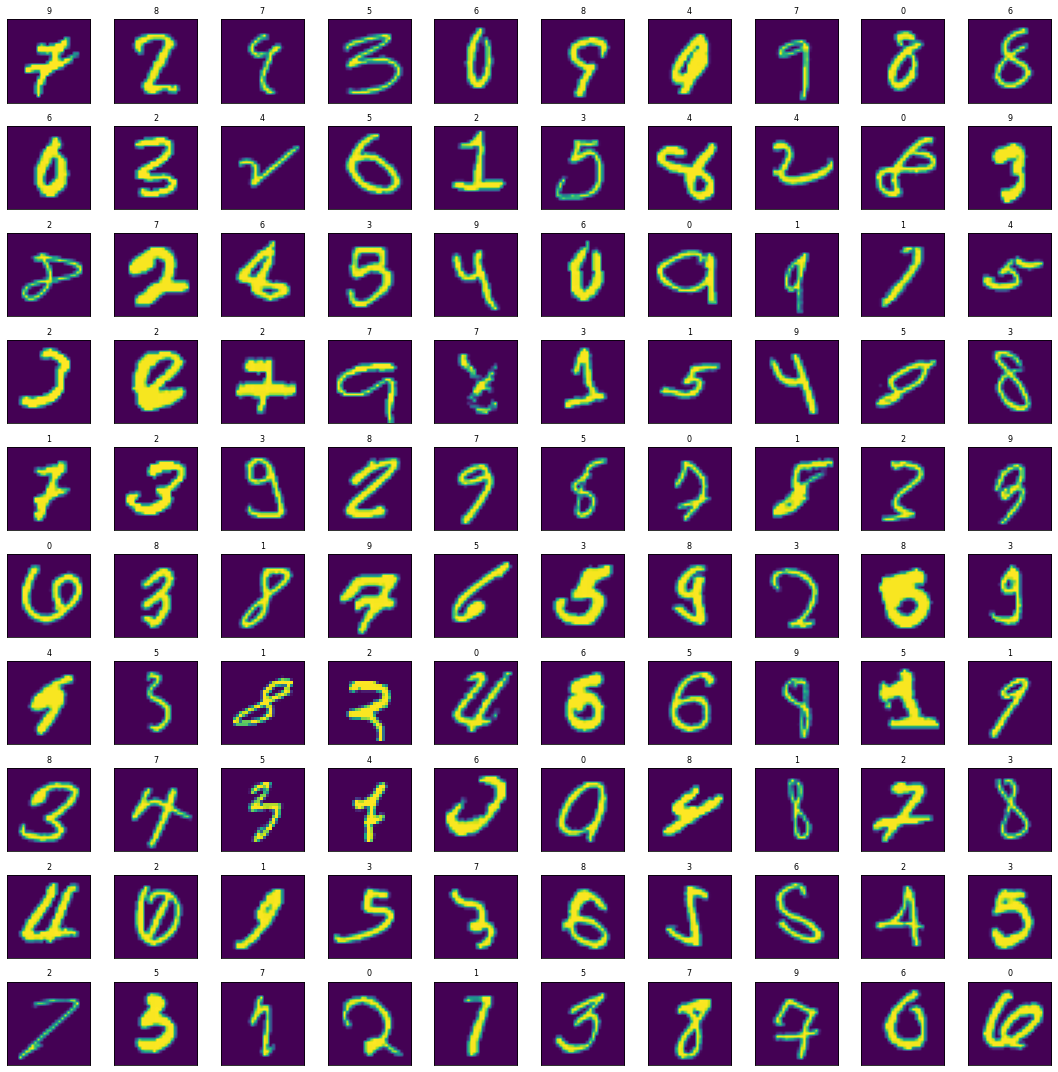

In [26]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [28]:
cm = confusion_matrix(y_test, y_pred)

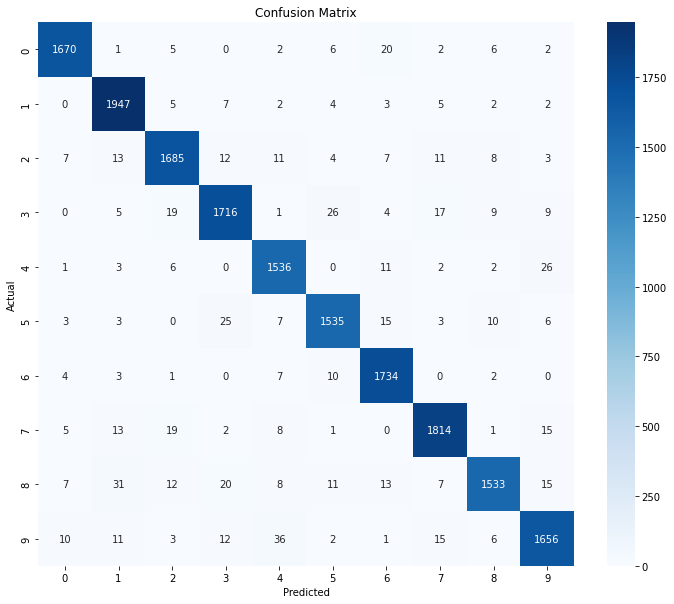

In [29]:
# Plot the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1714
           1       0.96      0.98      0.97      1977
           2       0.96      0.96      0.96      1761
           3       0.96      0.95      0.95      1806
           4       0.95      0.97      0.96      1587
           5       0.96      0.96      0.96      1607
           6       0.96      0.98      0.97      1761
           7       0.97      0.97      0.97      1878
           8       0.97      0.93      0.95      1657
           9       0.96      0.95      0.95      1752

    accuracy                           0.96     17500
   macro avg       0.96      0.96      0.96     17500
weighted avg       0.96      0.96      0.96     17500



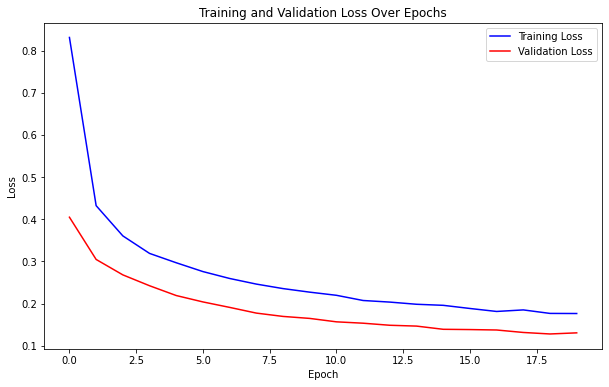

In [31]:
# Plot the training loss and validation loss over epochs
train_loss = net.history[:, 'train_loss']
valid_loss = net.history[:, 'valid_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(valid_loss, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [33]:
# Predict probabilities for each class
y_probas = net.predict_proba(X_test)

# Binarize the labels if not already one-hot encoded
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

n_classes = y_test_bin.shape[1]

# Initialize arrays to store precision and recall for each class
precisions = []
recalls = []

for class_label in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, class_label], y_probas[:, class_label])
    precisions.append(precision)
    recalls.append(recall)


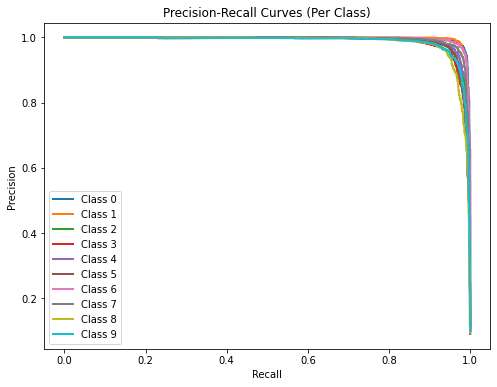

In [34]:
# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recalls[i], precisions[i], lw=2, label=f'Class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (Per Class)')
plt.legend()
plt.show()


In [35]:
from sklearn.model_selection import learning_curve

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.0904       0.6871        1.8023  0.0694
      2        1.5510       0.7871        1.2393  0.0664
      3        1.1306       0.8186        0.9138  0.0738
      4        0.9203       0.8371        0.7501  0.0654
      5        0.7968       0.8629        0.6537  0.0654
      6        0.7192       0.8643        0.5897  0.0743
      7        0.6547       0.8700        0.5439  0.0718
      8        0.6042       0.8771        0.5101  0.0703
      9        0.5654       0.8814        0.4830  0.0694
     10        0.5438       0.8800        0.4633  0.0699
     11        0.5316       0.8843        0.4507  0.0668
     12        0.5237       0.8857        0.4298  0.0664
     13        0.4671       0.8871        0.4226  0.0713
     14        0.4600       0.8843        0.4120  0.0739
     15        0.4526       0.8829        0.4009  0.0633
     16        0.4520       0.8

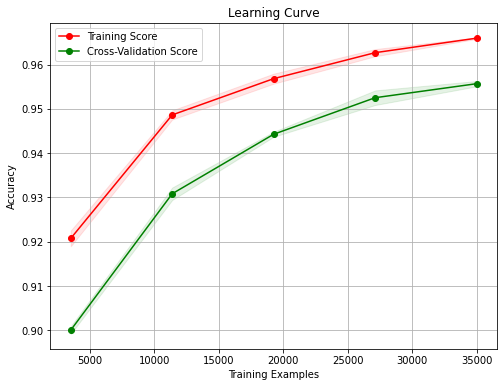

In [36]:
# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(net, X_train, y_train, cv=3, train_sizes=np.linspace(0.1, 1.0, 5))


# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create the learning curve graph
plt.figure(figsize=(8, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")
plt.legend(loc="best")
plt.show()



```
# This is formatted as code
```

# Convolutional Network
PyTorch expects a 4 dimensional tensor as input for its 2D convolution layer. The dimensions represent:
* Batch size
* Number of channel
* Height
* Width

As initial batch size the number of examples needs to be provided. MNIST data has only one channel. As stated above, each MNIST vector represents a 28x28 pixel image. Hence, the resulting shape for PyTorch tensor needs to be (x, 1, 28, 28).

In [37]:
XCnn = X.reshape(-1, 1, 28, 28)

In [38]:
XCnn.shape

(70000, 1, 28, 28)

In [39]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [40]:
XCnn_train.shape, y_train.shape, XCnn_test.shape, y_test.shape

((52500, 1, 28, 28), (52500,), (17500, 1, 28, 28), (17500,))

In [41]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [42]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [43]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.4333       0.9723        0.0886  31.7594
      2        0.1616       0.9791        0.0654  38.1200
      3        0.1256       0.9827        0.0571  41.7104
      4        0.1103       0.9843        0.0500  26.8892
      5        0.0987       0.9866        0.0467  28.0497
      6        0.0939       0.9862        0.0422  38.1193
      7        0.0854       0.9878        0.0374  27.7975
      8        0.0806       0.9869        0.0401  27.7066
      9        0.0798       0.9884        0.0369  27.1063
     10        0.0733       0.9878        0.0383  26.9736


In [44]:
y_pred_cnn = cnn.predict(XCnn_test)

In [45]:
accuracy_score(y_test, y_pred_cnn)

0.9871428571428571

An accuracy of >98% should suffice for this example!

Let's see how we fare on the examples that went wrong before:

In [46]:
accuracy_score(y_test[error_mask], y_pred_cnn[error_mask])

0.7507418397626113

Over 70% of the previously misclassified images are now correctly identified.

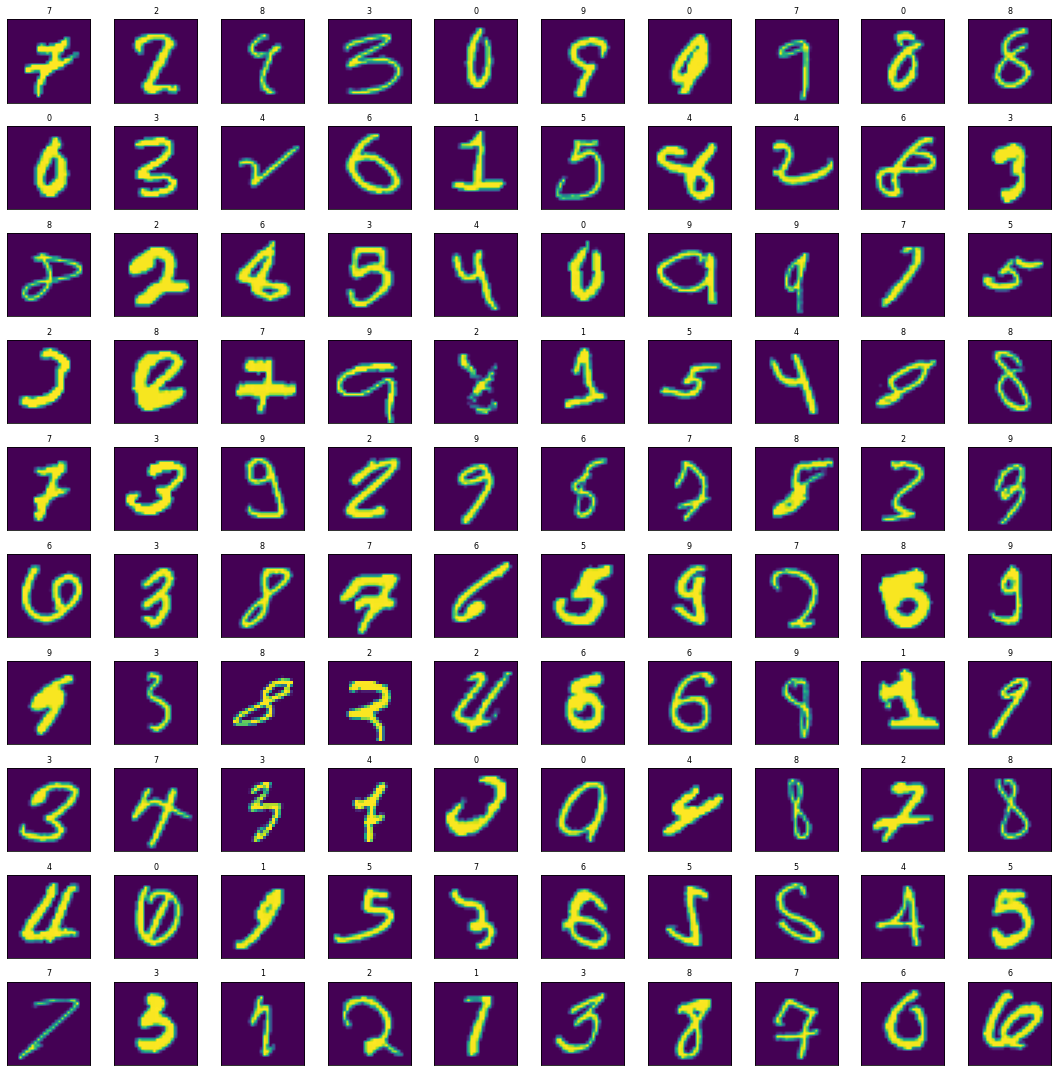

In [47]:
plot_example(X_test[error_mask], y_pred_cnn[error_mask])

In [48]:
cm = confusion_matrix(y_test, y_pred_cnn)

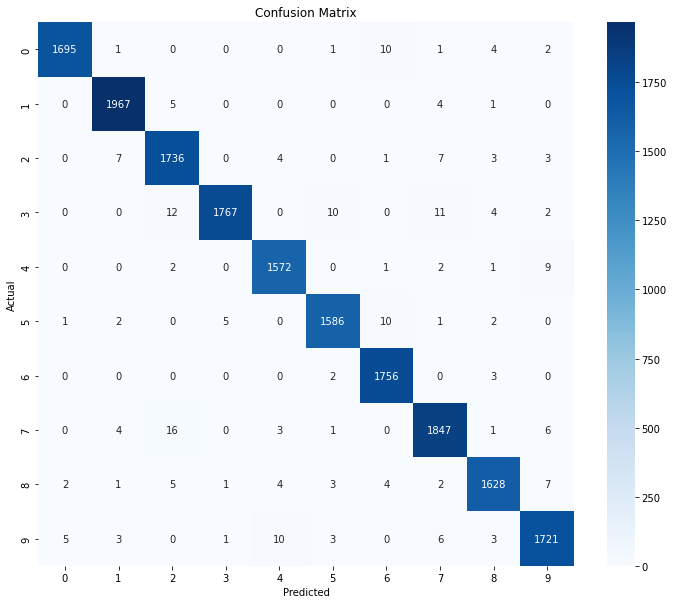

In [49]:
# Plot the confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [50]:
# Generate a classification report
report = classification_report(y_test, y_pred_cnn)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1714
           1       0.99      0.99      0.99      1977
           2       0.98      0.99      0.98      1761
           3       1.00      0.98      0.99      1806
           4       0.99      0.99      0.99      1587
           5       0.99      0.99      0.99      1607
           6       0.99      1.00      0.99      1761
           7       0.98      0.98      0.98      1878
           8       0.99      0.98      0.98      1657
           9       0.98      0.98      0.98      1752

    accuracy                           0.99     17500
   macro avg       0.99      0.99      0.99     17500
weighted avg       0.99      0.99      0.99     17500



## Preprocess and Save the Data

In [51]:
#import pickle
#preprocessed_data = {'X': X, 'y': y}
#with open('data/mnist.pkl', 'wb') as file:
 #   pickle.dump(preprocessed_data, file) 